## Data and Network Visualization Project: USA Airports Network

In [1]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

Airports and routes datasets have been downloaded from https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat and https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat. I could upload them using URL within read_csv, but due to multiple changes and error fixing, decided to keep it simple and use the pre=downloaded files from local computer.

In [2]:
airports_df = pd.read_csv('airports.dat', header = None, names=['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'lon', 'alt', 'timezone', 'dst', 'tz_db','type','source'])
routes_df = pd.read_csv('routes.dat', header=None, names=['airline', 'airline_id', 'source', 'source_id', 'dest', 'dest_id', 'codeshare', 'stops', 'equipment'])


In [3]:
airports_df.head()

,id,name,city,country,iata,icao,lat,lon,alt,timezone,dst,tz_db,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
routes_df.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


Next, I clean the data to keep only the necessary columns and dropping military and otber types of airports other than normal commercial airports.

In [5]:
us_airports_df = airports_df[airports_df['country'] == 'United States']
us_airports_df = us_airports_df.loc[:,['iata', 'name', 'lon', 'lat', 'icao']]
us_airports_df = us_airports_df.drop(index=us_airports_df[us_airports_df['iata'] == r'\N'].index)

In [6]:
us_airports_df.head()

,iata,name,lon,lat,icao
3212,BTI,Barter Island LRRS Airport,-143.582001,70.134003,PABA
3214,LUR,Cape Lisburne LRRS Airport,-166.110001,68.875099,PALU
3215,PIZ,Point Lay LRRS Airport,-163.005005,69.732903,PPIZ
3216,ITO,Hilo International Airport,-155.048004,19.721399,PHTO
3217,ORL,Orlando Executive Airport,-81.332901,28.545500,KORL


In [7]:
us_airports_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 3212 to 7665
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iata    1251 non-null   object 
 1   name    1251 non-null   object 
 2   lon     1251 non-null   float64
 3   lat     1251 non-null   float64
 4   icao    1251 non-null   object 
dtypes: float64(2), object(3)
memory usage: 58.6+ KB


Same cleaning procedure with routes dataset where I keep only the source and destination airports and calculate number of airlines that operate along that route.

In [8]:
# Filter the routes DataFrame to keep only the US routes
routes_us = routes_df[(routes_df['source'].isin(us_airports_df['iata'])) &
                      (routes_df['dest'].isin(us_airports_df['iata']))]

# Reset the index
routes_us.reset_index(drop=True, inplace=True)

In [9]:
routes_us = routes_us.loc[:, ['source', 'dest', 'airline']]
routes_us['num_airlines'] = routes_us.groupby(['source', 'dest'])['airline'].transform('count')
routes_us = routes_us.loc[:, ['source', 'dest', 'num_airlines']]

In [10]:
routes_us.tail()

,source,dest,num_airlines
10513,SHR,DEN,1
10514,SOW,FMN,3
10515,SOW,PHX,3
10516,VIS,LAX,1
10517,WRL,CYS,3


Finally, I create graph using networkx because I'm working on Windows and Jupyter Notebook.

In [11]:
import networkx as nx

graph = nx.from_pandas_edgelist(routes_us, source = 'source', target = 'dest',
                        edge_attr = 'num_airlines',create_using = nx.DiGraph())

In [48]:
# Get the top 10 airports by degree

degrees = dict(graph.degree())
top_10_airports = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_airports = [x[0] for x in top_10_airports]

node_colors = ['r' if node in top_10_airports else '#3e65a0' for node in graph.nodes()]
node_alpha = [0.4 if node not in top_10_airports else 0.8 for node in graph.nodes()]

In [15]:
# Compute node size based on degree and define edge_width
node_size = [d * 10 for n, d in graph.degree()]
edge_width = [e['num_airlines'] for u, v, e in graph.edges(data=True)]

In [37]:
# Define event handler for hovering over a node
def on_hover(event):
    node = event.artist
    edges = list(graph.edges(node))
    for u, v in edges:
        edge = graph[u][v]
        edge['alpha'] = 1
    plt.draw()

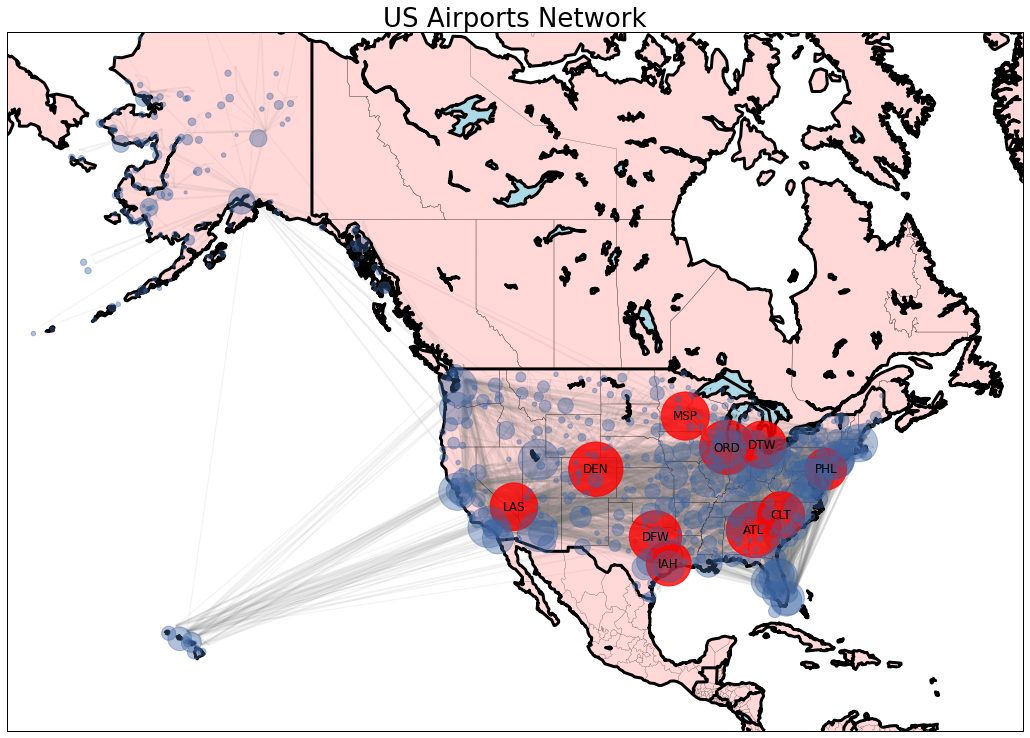

In [49]:
fig, ax = plt.subplots(figsize=(15, 10))

m = Basemap(
         projection='merc',
         llcrnrlon=-180,
         llcrnrlat=10,
         urcrnrlon=-50,
         urcrnrlat=70,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)

mx, my = m(us_airports_df['lon'].values, us_airports_df['lat'].values)
pos = {}
for count, elem in enumerate (us_airports_df['iata']):
    pos[elem] = (mx[count], my[count])

m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=3)
m.fillcontinents(color='#FFD8D7', lake_color='#ADD8E6') 
m.drawmapboundary(fill_color='white')

nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(),
                       node_color=node_colors, alpha=node_alpha, node_size=node_size)
nx.draw_networkx_labels(graph, pos, {n: n for n in top_10_airports}, font_size=12)
nx.draw_networkx_edges(G=graph, pos=pos, edge_color='grey',
                       alpha=0.05, arrows=False, width=edge_width)

# Add event handler for hovering over a node
fig.canvas.mpl_connect('motion_notify_event', on_hover)

plt.tight_layout()
plt.title("US Airports Network", fontsize=26)
plt.show()

Ideally, it would be much more interesting if my codes using mpld3 worked. Then the plot would be interactive and show the name of the airport on hovering the nodes and the edges from that airport would be visible only on hovering too. Unfortunately, interactivity did not work even though the code did not generate errors. <br/>
The graph is pretty simple, the node size reflects the degree and top 10 airports are colored red and have their IATA codes on them for compactness.